# Vowel Speech Recognition Dataset

This dataset captures vowel sounds from multiple speakers in a speech recognition context. The data was collected as follows:

- **Training set**: 8 speakers × 11 words × 6 repetitions = 528 observations
- **Test set**: 7 speakers × 11 words × 6 repetitions = 462 observations

## Dataset Structure
- **Features**: 10 predictors derived from digitized speech signals using standard speech recognition processing techniques  
- **Classes**: 11 different vowel sounds, each represented in a distinct word

## Vowel-Word Mapping
| IPA Symbol | Word  | Sound Example |
|------------|-------|---------------|
| i:         | heed  | as in "see"   |
| I          | hid   | as in "sit"   |
| E          | head  | as in "bed"   |
| A          | had   | as in "bad"   |
| a:         | hard  | as in "car"   |
| O          | hod   | as in "hot"   |
| C          | hoard | as in "core"  |
| U          | hood  | as in "put"   |
| u:         | who'd | as in "blue"  |
| 3:         | heard | as in "bird"  |
| Y          | hud   | as in "but"   |

This phonetic classification problem presents an interesting challenge in speech recognition, involving the distinction between closely related vowel sounds in spoken English.

Note: The 10 predictors are derived through complex signal processing of the digitized speech, following standard practices in speech recognition research.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd

%matplotlib inline


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
BLUE, ORANGE, GRAY1, GRAY4 = '#57B5E8', '#E69E00', '#231F20', '#646369'

In [3]:
def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

In [4]:
# load training and test data sets from the file
df_train = pd.read_csv("vowel_dataset/train.txt")
df_test = pd.read_csv("vowel_dataset/test.txt")

df_train['is_train'] = 1
df_test['is_train'] = 0


df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

df.y = df.y - 1

df_train, df_test = df[df.is_train == 1], df[df.is_train == 0]

In [5]:
df_train.head()

,row.names,y,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,is_train
0,1,0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,1
1,2,1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,1
2,3,2,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,1
3,4,3,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,1
4,5,4,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,1


In [6]:
features = [f'x.{i+1}' for i in range(10)]

# split the data into training and test sets based on the flag
X_train, y_train = df_train[features].values, df_train.y.values
X_test, y_test = df_test[features].values, df_test.y.values

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

### Linear Regression 

In [8]:
# PAGE 103. Here each of the response categories are coded via an indicator
#           variable.
Y_train_one_hot = OneHotEncoder(
    categories='auto'
).fit_transform(np.atleast_2d(y_train).T).toarray()

# PAGE 103. We fit a linear regression model to each of the columns of Y
#           simultaneously
lr = LinearRegression().fit(X_train, Y_train_one_hot)

# PAGE 103. identify the largest component and classify accordingly;
y_train_hat = np.argmax(lr.predict(X_train), axis=1)
y_test_hat = np.argmax(lr.predict(X_test), axis=1)

# PAGE 106. There are K = 11 classes in p = 10 dimensions. This is a difficult
#           classification problem, and the best methods achieve around 40%
#           errors on the test data. The main point here is summarized in
#           Table 4.1; linear regression has an error rate of 67%, while a
#           close relative, linear discriminant analysis, has an error rate of
#           56%. It seems that masking has hurn in this case. While all the
#           other methods in this chapter are based on linear functions of x as
#           well, they use them in such a way that avoids this masking problem.
lr_train_error = error_rate(y_train, y_train_hat)
lr_test_error = error_rate(y_test, y_test_hat)
print(f'Linear regression {lr_train_error:.2f} {lr_test_error:.2f}')

Linear regression 0.48 0.67


### Linear Discriminant Analysis 

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [10]:
# PAGE 108. Linear discriminant analysis (LDA) arises in the special case when
#           we assume that the classes have a common covariance matrix Σk=Σ∀k.
lda = LinearDiscriminantAnalysis(n_components=2).fit(X_train, y_train)
lda_train_error = error_rate(y_train, lda.predict(X_train))
lda_test_error = error_rate(y_test, lda.predict(X_test))
print(f'LDA {lda_train_error:.2f} {lda_test_error:.2f}')

LDA 0.32 0.56


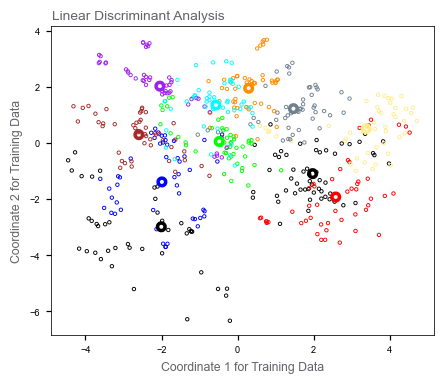

In [11]:
# PAGE 107. Figure 4.4. A two-dimensional plot of the vowel training data.
#           There are eleven classes with X in R^10, and this is the best view
#           in terms of LDA model (Section 4.3.3). The heavy circles are the
#           projected means vectors for each classes. The class overlap is
#           considerable.
X_reduced = lda.transform(X_train)
means = lda.transform(lda.means_)

# define colors for classes
colors = np.array([
    '#000000', '#0000FF', '#A52A2A', '#A020F0', '#FF8C00', '#00FFFF',
    '#708090', '#FFEC8B', '#000000', '#FF0000', '#00FF00'])
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], facecolors='none',
           edgecolors=colors[y_train], s=5, linewidth=0.6)
ax.scatter(means[:, 0], means[:, 1], facecolors='none', edgecolors=colors,
           s=5, linewidth=5)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.text(-4.89, 4.4, 'Linear Discriminant Analysis', color=GRAY4, fontsize=9)
ax.set_xlabel('Coordinate 1 for Training Data', color=GRAY4, fontsize=8)
_ = ax.set_ylabel('Coordinate 2 for Training Data', color=GRAY4, fontsize=8)

### Quadratic Discriminant Analysis

In [12]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [13]:
# PAGE 110. Getting back to the general discriminant problem (4.8), if the Σk
#           are not assumed to be equal, then the convenient cancellations in
#           (4.9) do not occur; in particular the pieces quadratic in x remain.
#           We then get quadratic discriminant functions (QDA).
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
qda_train_error = error_rate(y_train, qda.predict(X_train))
qda_test_error = error_rate(y_test, qda.predict(X_test))
print(f'QDA {qda_train_error:.2f} {qda_test_error:.2f}')

QDA 0.01 0.53


In [14]:
# PAGE 112. Friedman (1989) proposed a compromise between LDA and QDA, which
#           allows one to shrink the separate covariances of QDA toward a
#           common covariance as in LDA. These methods are very similar in
#           ﬂavor to ridge regression. The regularized covariance matrices have
#           the form (4.13)
alphas = np.linspace(0, 1, 51)
rda_train_error, rda_test_error = [], []

# calculate training-test errors for each alpha value
for alpha in alphas:
    rda = QuadraticDiscriminantAnalysis(
        reg_param=1-alpha
    ).fit(X_train, y_train)
    rda_train_error.append(error_rate(y_train, rda.predict(X_train)))
    rda_test_error.append(error_rate(y_test, rda.predict(X_test)))

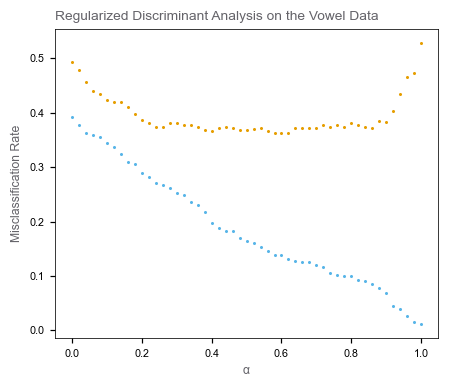

In [15]:
# PAGE 112. FIGURE 4.7. Test and training errors for the vowel data, using
#           regularized discriminant analysis with a series of values of
#           α ∈ [0,1]. The optimum for the test data occurs around α = 0.9,
#           close to quadratic discriminant analysis.
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax.scatter(alphas, rda_train_error, c=BLUE, s=1)
ax.scatter(alphas, rda_test_error, c=ORANGE, s=1)
ax.text(-0.05, 0.57, 'Regularized Discriminant Analysis on the Vowel Data',
        color=GRAY4, fontsize=9)
ax.set_xlabel('α', color=GRAY4, fontsize=8)
ax.set_ylabel('Misclassification Rate', color=GRAY4, fontsize=8)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)

### Reduced-Rank Linear Discriminant Analysis 

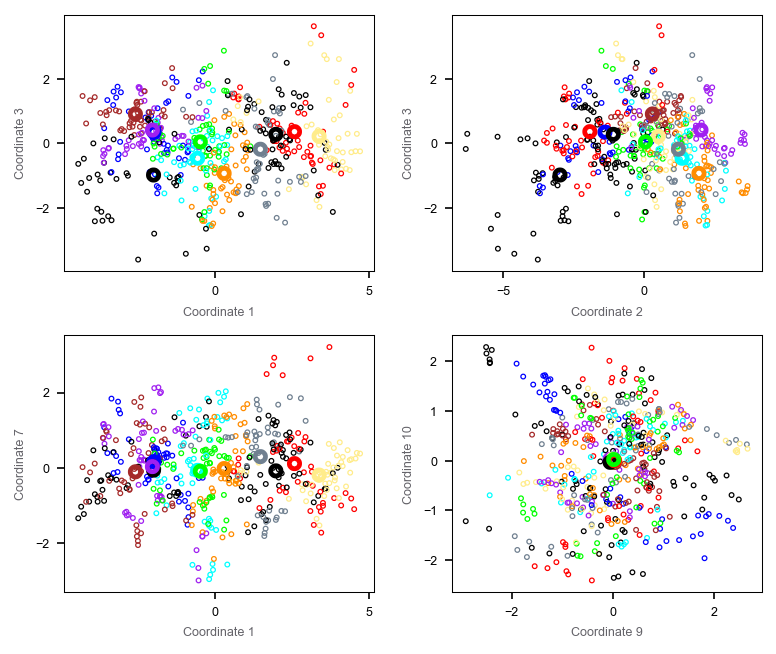

In [16]:
# PAGE 113. So far we have discussed LDA as a restricted Gaussian classiﬁer.
#           Part of its popularity is due to an additional restriction that
#           allows us to view informative low-dimensional projections of the
#           data. The K centroids in p-dimensional input space lie in an affine
#           subspace of dimension ≤ K−1, and if p is much larger than K, this
#           will be a considerable drop in dimension.
lda = LinearDiscriminantAnalysis(n_components=10).fit(X_train, y_train)
X_reduced = lda.transform(X_train)
means = lda.transform(lda.means_)


# plot point and centroid projections on i-th x j-th canonical variates
def plot_projections(ax, i, j):
    ax.scatter(X_reduced[:, i], X_reduced[:, j], facecolors='none',
               edgecolors=colors[y_train], s=5, linewidth=0.6)
    ax.scatter(means[:, i], means[:, j], facecolors='none', edgecolors=colors,
               s=5, linewidth=5)
    for t in ax.get_yticklabels() + ax.get_xticklabels():
        t.set_fontsize(6)
    ax.set_xlabel(f'Coordinate {i+1}', color=GRAY4, fontsize=6)
    ax.set_ylabel(f'Coordinate {j+1}', color=GRAY4, fontsize=6)

# PAGE 115. FIGURE 4.8. Four projections onto pairs of canonical variates.
#           Notice that as the rank of the canonical variates increases, the
#           centroids become less spread out. In the lower right panel they
#           appear to be superimposed, and the classes most confused.
fig, axarr = plt.subplots(2, 2, figsize=(6, 5), dpi=150)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plot_projections(axarr[0, 0], 0, 2)
plot_projections(axarr[0, 1], 1, 2)
plot_projections(axarr[1, 0], 0, 6)
plot_projections(axarr[1, 1], 8, 9)

In [17]:
# PAGE 117. There are 11 classes and 10 variables, and hence 10 possible
#           dimensions for the classifier. We can compute the training and test
#           error in each of these hierarchical subspaces; Figure 4.10 shows
#           the results. Figure 4.11 shows the decision boundaries for the
#           classiﬁer based on the two-dimensional LDA solution.
X_test_reduced = lda.transform(X_test)
n_dimensions = list(range(1, 11))
rda_train_error, rda_test_error = [], []
for i in n_dimensions:
    rda = LinearDiscriminantAnalysis().fit(X_reduced[:, :i], y_train)
    rda_train_error.append(error_rate(y_train, rda.predict(X_reduced[:, :i])))
    rda_test_error.append(
        error_rate(y_test, rda.predict(X_test_reduced[:, :i])))

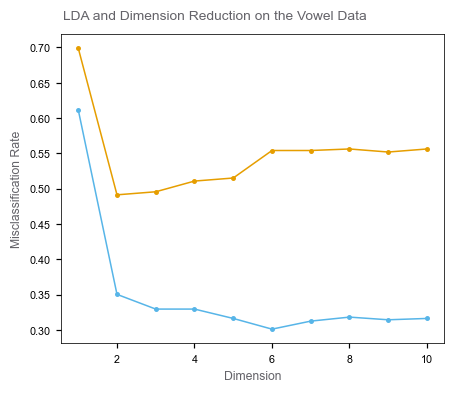

In [18]:
# PAGE 117. FIGURE 4.10. Training and test error rates for the vowel data, as a
#           function of the dimension of the discriminant subspace. In this
#           case the best error rate is for dimension 2. Figure 4.11 shows the
#           decision boundaries in this space.
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax.scatter(n_dimensions, rda_train_error, c=BLUE, s=5)
ax.scatter(n_dimensions, rda_test_error, c=ORANGE, s=5)
ax.plot(n_dimensions, rda_train_error, c=BLUE, linewidth=1)
ax.plot(n_dimensions, rda_test_error, c=ORANGE, linewidth=1)
ax.text(0.6, 0.74, 'LDA and Dimension Reduction on the Vowel Data',
        color=GRAY4, fontsize=9)
ax.set_xlabel('Dimension', color=GRAY4, fontsize=8)
ax.set_ylabel('Misclassification Rate', color=GRAY4, fontsize=8)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)

In [19]:
# PAGE 110. For this ﬁgure and many similar figures in the book we compute the
#           decision boundaries by an exhaustive contouring method. We compute
#           the decision rule on a fine lattice of points, and then use
#           contouring algorithms to compute the boundaries.
rda = LinearDiscriminantAnalysis().fit(X_reduced[:, :2], y_train)
grid_size = 2000
X = np.transpose([np.tile(np.linspace(-4.5, 5, grid_size), grid_size),
                  np.repeat(np.linspace(-6.5, 4.5, grid_size), grid_size)])
y = rda.predict(X)
X0 = X[:, 0].reshape(grid_size, grid_size)
X1 = X[:, 1].reshape(grid_size, grid_size)
Y = y.reshape(grid_size, grid_size)

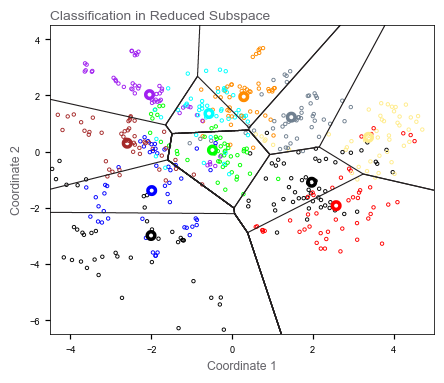

In [20]:
# PAGE 118. FIGURE 4.11. Decision boundaries for the vowel training data, in
#           the two-dimensional subspace spanned by the ﬁrst two canonical
#           variates. Note that in any higher-dimensional subspace, the
#           decision boundaries are higher-dimensional affine planes, and could
#           not be represented as lines.
fig, ax = plt.subplots(figsize=(4.5, 3.65), dpi=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], facecolors='none',
           edgecolors=colors[y_train], s=5, linewidth=0.6)
ax.scatter(means[:, 0], means[:, 1], facecolors='none', edgecolors=colors,
           s=5, linewidth=5)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.text(-4.5, 4.7, 'Classification in Reduced Subspace', color=GRAY4,
        fontsize=9)
ax.set_xlabel('Coordinate 1', color=GRAY4, fontsize=8)
ax.set_ylabel('Coordinate 2', color=GRAY4, fontsize=8)
_ = ax.contour(X0, X1, Y, np.linspace(0, 9, 10)+0.5, colors=GRAY1,
               linewidths=[0.7]*10)

### Logistic Regression 

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [22]:

# PAGE 119. The logistic regression model arises from the desire to model the
#           posterior probabilities of the K classes via linear functions in x,
#           while at the same time ensuring that they sum to one and remain in
#           [0,1]. The model has the form (4.17).
logreg = LogisticRegression(
    C=11, multi_class='multinomial', solver='lbfgs', max_iter=1000000
).fit(X_train, y_train)
logreg_train_error = error_rate(y_train, logreg.predict(X_train))
logreg_test_error = error_rate(y_test, logreg.predict(X_test))
print(f'Logistic Regression {logreg_train_error:.2f} {logreg_test_error:.2f}')

Logistic Regression 0.23 0.51


### Linear Models Summary 

In [23]:
# PAGE 107. TABLE 4.1. Training and test error rates using a variety of linear
#           techniques on the vowel data. There are eleven classes in ten
#           dimensions, of which three account for 90% of the variance (via a
#           principal component analysis). We see that linear regression is
#           hurt by masking, increasing the test and training error by over
#           10%.
models = ['Linear regression', 'Linear discriminant analysis',
          'Quadratic discriminant analysis', 'Logistic regression']
train_errors = [lr_train_error, lda_train_error, qda_train_error,
                logreg_train_error]
test_errors = [lr_test_error, lda_test_error, qda_test_error,
               logreg_test_error]
print('                      Technique     Error Rates')
print('                                  Traing     Test')
for model, train_error, test_error in zip(models, train_errors, test_errors):
    print(f'{model:>31}   {train_error:.2f} {test_error:>10.2f}')

                      Technique     Error Rates
                                  Traing     Test
              Linear regression   0.48       0.67
   Linear discriminant analysis   0.32       0.56
Quadratic discriminant analysis   0.01       0.53
            Logistic regression   0.23       0.51


### FAD/MARS & MDA

In [24]:
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
#from pyearth import Earth
from sklearn.preprocessing import PolynomialFeatures

In [25]:
class FlexibleDiscriminantAnalysis(BaseEstimator, TransformerMixin):
    """Flexible Discriminant Analysis
    A classifier with nonlinear decision boundary, based on adaptive
    multivariate regression and optimal scoring approach.
    Parameters
    ----------
    model :
        Multivariate nonparameteric regression. Should have fit method,
        transform method (for basis expansion).
    n_components :
        Number of components for dimensionality reduction.
    """
    def __init__(self, model, n_components: int = None):
        self.model = model
        self.n_components = n_components

    def fit(self,
            X: np.ndarray,
            y: np.array) -> 'FlexibleDiscriminantAnalysis':
        """Fit FlexibleDiscriminantAnalysis model according to the given
           training data and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        # relabel target values to start from zero
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        self.classes_ = label_encoder.classes_
        _, counts_elements = np.unique(y, return_counts=True)
        # PAGE 440. We create an N × K indicator response matrix Y
        Y = OneHotEncoder(
            categories='auto'
        ).fit_transform(np.atleast_2d(y).T).toarray()

        # PAGE 441. Multivariate nonparametric regression. Fit a multiresponse,
        #           adaptive nonparametric regression of Y on X
        self.model.fit(X, Y)
        X_exp = self.model.transform(X)
        lr = LinearRegression(fit_intercept=False).fit(X_exp, Y)
        Y_hat = lr.predict(X_exp)

        # PAGE 441. Optimal scores. Compute the eigen-decomposition of
        #           Y.T @ Y_hat
        evals, evecs = np.linalg.eig(Y.T @ Y_hat)
        evals_ord = np.argsort(evals)[::-1]
        evals = evals[evals_ord]
        evecs = evecs[:, evals_ord]
        priors = Y.T @ Y / len(y)
        evecs = evecs / np.sqrt(np.diag(priors))

        # PAGE 441. Update the model from step 1 using the optimal scores.
        self.coef_ = evecs.T @ lr.coef_
        R = self.transform(X)
        self.lda_ = LinearDiscriminantAnalysis().fit(R, y)
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Project data to maximize class separation.
        Parameters
        ----------
        X :
            Input data.
        Returns
        -------
        X_new :
            Transformed data.
        """
        X_exp = self.model.transform(X)
        R = X_exp @ self.coef_.T
        if self.n_components is None:
            return R
        return R[:, :self.n_components]

    def predict(self, X: np.ndarray) -> np.array:
        X_new = self.transform(X)
        return self.classes_[self.lda_.predict(X_new)]

In [26]:
fda_degree1 = FlexibleDiscriminantAnalysis(
    PolynomialFeatures(degree=1),
    n_components=4
).fit(X_train, y_train)
fda_degree1_train_error = error_rate(y_train, fda_degree1.predict(X_train))
fda_degree1_test_error = error_rate(y_test, fda_degree1.predict(X_test))

In [27]:
fda_degree2 = FlexibleDiscriminantAnalysis(
    PolynomialFeatures(degree=2),
    n_components=14
).fit(X_train, y_train)
fda_degree2_train_error = error_rate(y_train, fda_degree2.predict(X_train))
fda_degree2_test_error = error_rate(y_test, fda_degree2.predict(X_test))

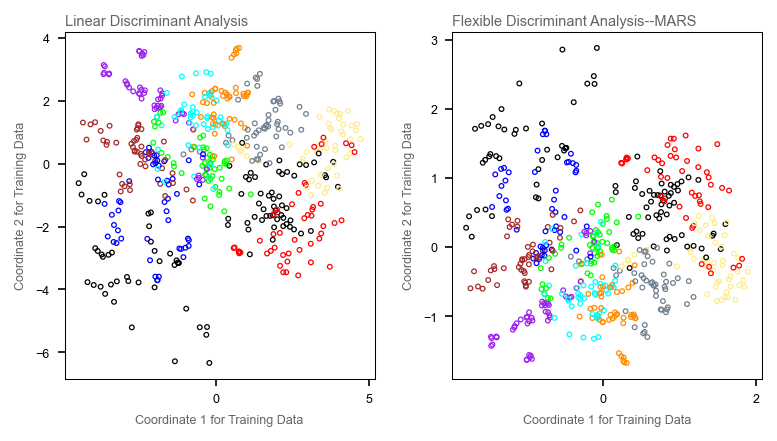

In [28]:
# PAGE 443. FIGURE 12.10. The left plot shows the first two LDA canonical
#           variates for the vowel training data. The right plot shows the
#           corresponding projection when FDA/BRUTO is used to fit the model;
#           plotted are the fitted regression functions ηˆ1(xi) and ηˆ2(xi).
#           Notice the improved separation. The colors represent the eleven
#           different vowel sounds.
def plot_scatter(ax, X_reduced, title):
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], facecolors='none',
               edgecolors=colors[y_train], s=5, linewidth=0.6)
    for t in ax.get_yticklabels() + ax.get_xticklabels():
        t.set_fontsize(6)
    ax.set_xlabel(f'Coordinate 1 for Training Data', color=GRAY4, fontsize=6)
    ax.set_ylabel(f'Coordinate 2 for Training Data', color=GRAY4, fontsize=6)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.text(xlim[0], ylim[1] + (ylim[1] - ylim[0])*0.02,
            title, color=GRAY4, fontsize=7)


# PAGE 115. FIGURE 4.8. Four projections onto pairs of canonical variates.
#           Notice that as the rank of the canonical variates increases, the
#           centroids become less spread out. In the lower right panel they
#           appear to be superimposed, and the classes most confused.
fig, axarr = plt.subplots(1, 2, figsize=(6, 3), dpi=150)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
plot_scatter(axarr[0], X_reduced, 'Linear Discriminant Analysis')
# used MARS instead of BRUTO
plot_scatter(axarr[1], fda_degree1.transform(X_train)[:, 1:],
             'Flexible Discriminant Analysis--MARS')

### Flexible Discriminant Models Summary

In [29]:
models = ['FDA/MARS (degree = 1)', 'FDA/MARS (degree = 2)']
train_errors = [fda_degree1_train_error, fda_degree2_train_error]
test_errors = [fda_degree1_test_error, fda_degree2_test_error]
print('                      Technique     Error Rates')
print('                                  Training     Test')
for model, train_error, test_error in zip(models, train_errors, test_errors):
    print(f'{model:>31}   {train_error:.2f} {test_error:>10.2f}')

                      Technique     Error Rates
                                  Training     Test
          FDA/MARS (degree = 1)   0.34       0.53
          FDA/MARS (degree = 2)   0.02       0.44
